# Exercises day 01

In [131]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import collections

### Testing Neumanns simple method

In [132]:
def neumann_four_digit(seed : int, break_point : int = None) -> tuple[list[float], list[int], list[int]]:
    """
        A function that generates a sequence of random numbers using the Neumann four digit method.
        
        :param seed: The seed for the Neumann generator.
        :param break_point: The number of iterations to run the generator for.
        
        :return: A tuple containing the sequence of random numbers, the sequence of x values, and the sequence of x^2 values.
    """
    
    if break_point is None:
        break_point = 10**6 # 1 million
    
    assert type(break_point) is int, "break_point must be an integer!"
    
    U = []
    xs = []
    xsquareds = []
    x = seed
    counter = 0
    while counter < break_point and x > 0:
        U.append(x / 10**4)
        xs.append(x)
        xsquareds.append(x ** 2)
        x = ((x ** 2) // 10**2) % 10**4
        counter += 1
    
    return U, xs, xsquareds

U, xs, xsquareds = neumann_four_digit(7182, 30)

print(f"U = \n{U}\n")
print(f"xs = \n{xs}\n")
print(f"xsquareds = \n{xsquareds}\n")

U = 
[0.7182, 0.5811, 0.7677, 0.9363, 0.6657, 0.3156, 0.9603, 0.2176, 0.7349, 0.0078, 0.006, 0.0036, 0.0012, 0.0001]

xs = 
[7182, 5811, 7677, 9363, 6657, 3156, 9603, 2176, 7349, 78, 60, 36, 12, 1]

xsquareds = 
[51581124, 33767721, 58936329, 87665769, 44315649, 9960336, 92217609, 4734976, 54007801, 6084, 3600, 1296, 144, 1]



## Ex. 1

Implement a Linear Congruental Generator

In [133]:
def linear_congruental_generator(multiplier : int, shift : int, modulus: int, x0 : int = None, break_point : int = None) -> tuple[list[int], list[float]]:
    """
        Generates a list of random numbers using the linear congruental generator method.
        
        NOTE: random_nums and U will have length 'modulus' if the parameters follows the conditions
        of Theorem 1 Maximum Cycle Length.

        :param multiplier: The multiplier (a) used in the formula.
        :param shift: The shift (c) used in the formula.
        :param modulus: The modulus (M) used in the formula.
        :param x0: initial value (x0) used in the formula. If not provided, a random value will be used.
        
        :return random_nums: a list of randomly generated numbers.
        :return U: a list of random numbers between 0 and 1.
    """
    
    assert type(modulus) is int, "Modulus must be an integer."
    assert modulus > 0, "Modulus must be greater than 0."
    
    if x0 is None:
        x0 = np.random.randint(0, modulus)
    
    if break_point is None:
        break_point = modulus
        
    random_nums = [x0]
    U = [x0 / modulus]
    random_nums_generated = 0
    while random_nums_generated < modulus and random_nums_generated < break_point:
        random_nums.append((multiplier * random_nums[-1] + shift) % modulus) 
        U.append(random_nums[-1] / modulus)
        random_nums_generated += 1
    
    return random_nums, U
        
    
    
    
    

Testing whether the Linear Congruental Generator works as presented in the slides

In [134]:
M = 16
a = 5
c = 1
x0 = 3

ranom_nums, U = linear_congruental_generator(multiplier=a, shift=c, modulus=M, x0=x0)

print(f"Random numbers: \n{ranom_nums}\n")
print(f"U: \n{U}\n")

Random numbers: 
[3, 0, 1, 6, 15, 12, 13, 2, 11, 8, 9, 14, 7, 4, 5, 10, 3]

U: 
[0.1875, 0.0, 0.0625, 0.375, 0.9375, 0.75, 0.8125, 0.125, 0.6875, 0.5, 0.5625, 0.875, 0.4375, 0.25, 0.3125, 0.625, 0.1875]



### Histogram

In [135]:
def plot_hist_and_corr(multiplier : int, shift : int, modulus: int, x0 : int = None, num_bins : int = None, num_scatter_points : int = None) -> None:
    """
        This function plots the histogram and corresponding correlation plot of a specific run of our LCG.
        
        :param multiplier: The multiplier (a) used in the formula.
        :param shift: The shift (c) used in the formula.
        :param modulus: The modulus (M) used in the formula.
        :param x0: initial value (x0) used in the formula. If not provided, a random value will be used.
        :param num_bins: number of bins in the histogram.
        :param num_scatter_points: number of points plotted in the correlation plot.
        
        :return: returns void.
    """
    if num_bins is None:
        num_bins = 10
    if x0 is None:
        # This is dumb, but we roll
        x0 = np.random.randint(0, modulus)
    if num_scatter_points is None:
        num_scatter_points = 100
        
    random_nums_hist, U_hist = linear_congruental_generator(multiplier=multiplier, shift=shift, modulus=modulus, x0=x0)
    
    # counts, bins = np.histogram(U_hist, bins=num_bins)
    plt.figure(figsize=(16, 9))
    plt.subplot(1,2,1)
    plt.title(f"Histogram of random numbers, with: \nM: {modulus}, a: {multiplier}, c: {shift}, x0: {x0}")
    plt.hist(U_hist, bins=num_bins)
    
    plt.subplot(1, 2, 2)
    plt.title("Correlation plot of $U_{i - 1}$ and $U_i$")
    plt.scatter(U_hist[:num_scatter_points], U_hist[1:(num_scatter_points + 1)], s=[0.1]*num_scatter_points)
    
    plt.show()
    
    
    
    

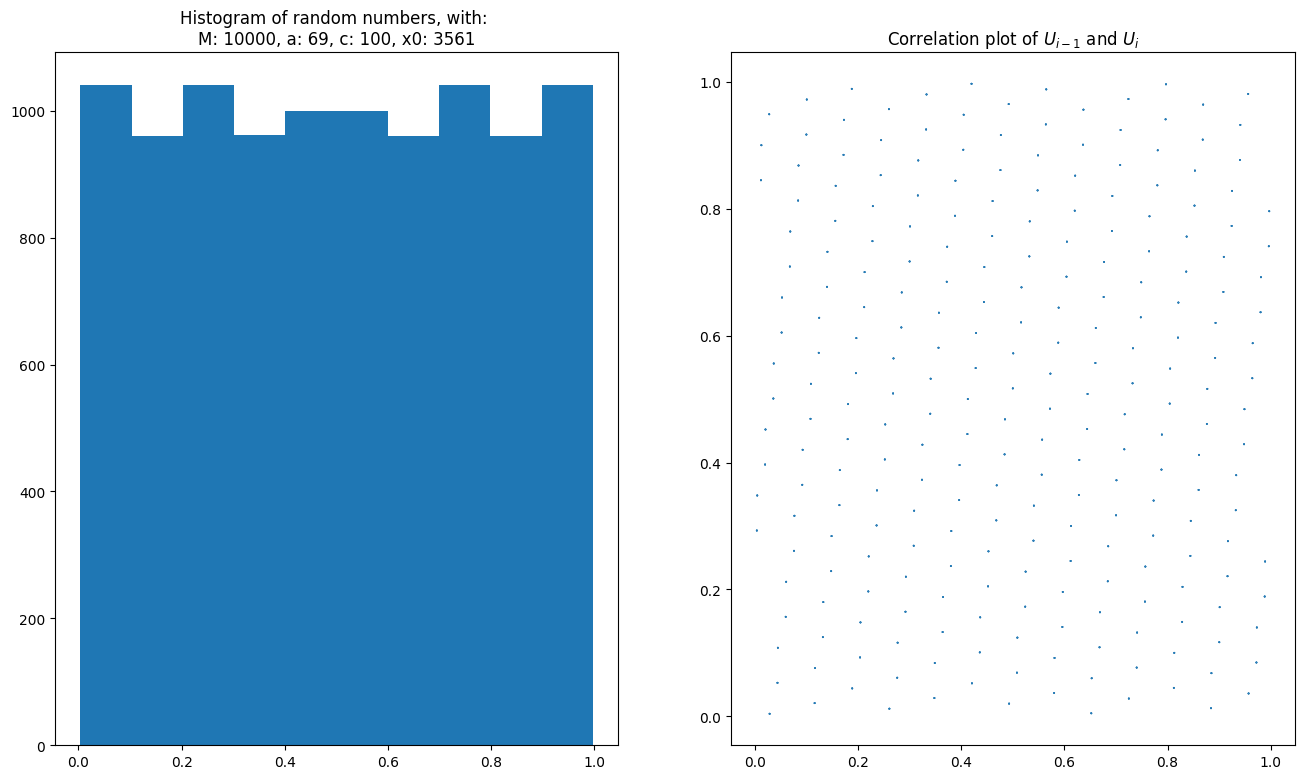

In [136]:
M_hist = 10**4
multiplier_hist = 69
shift_hist = 100
x0_hist = 420

plot_hist_and_corr(multiplier = multiplier_hist, shift =shift_hist, modulus = M_hist, x0 = None, num_bins = None, num_scatter_points = 1000)


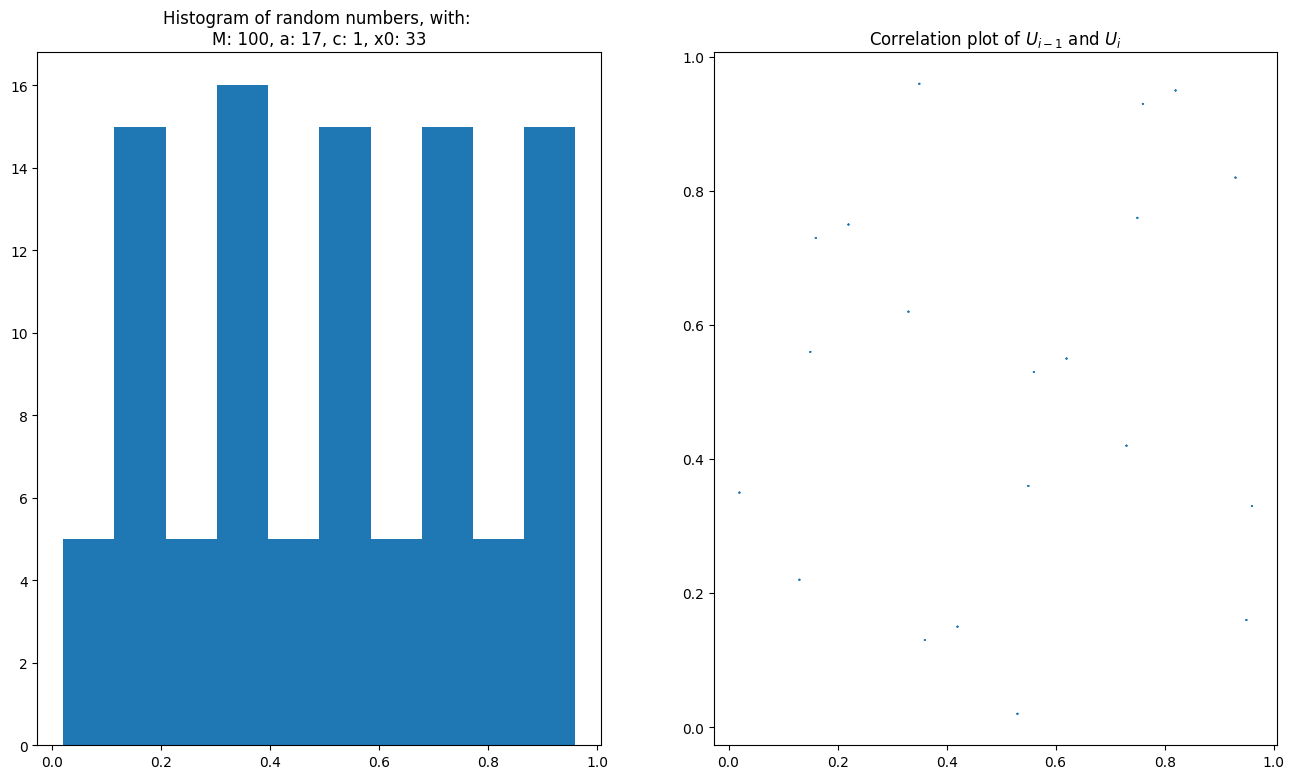

In [137]:
M_hist = 100
multiplier_hist = 17
shift_hist = 1
x0_hist = 69

plot_hist_and_corr(multiplier = multiplier_hist, shift =shift_hist, modulus = M_hist, x0 = None, num_bins = None, num_scatter_points = None)

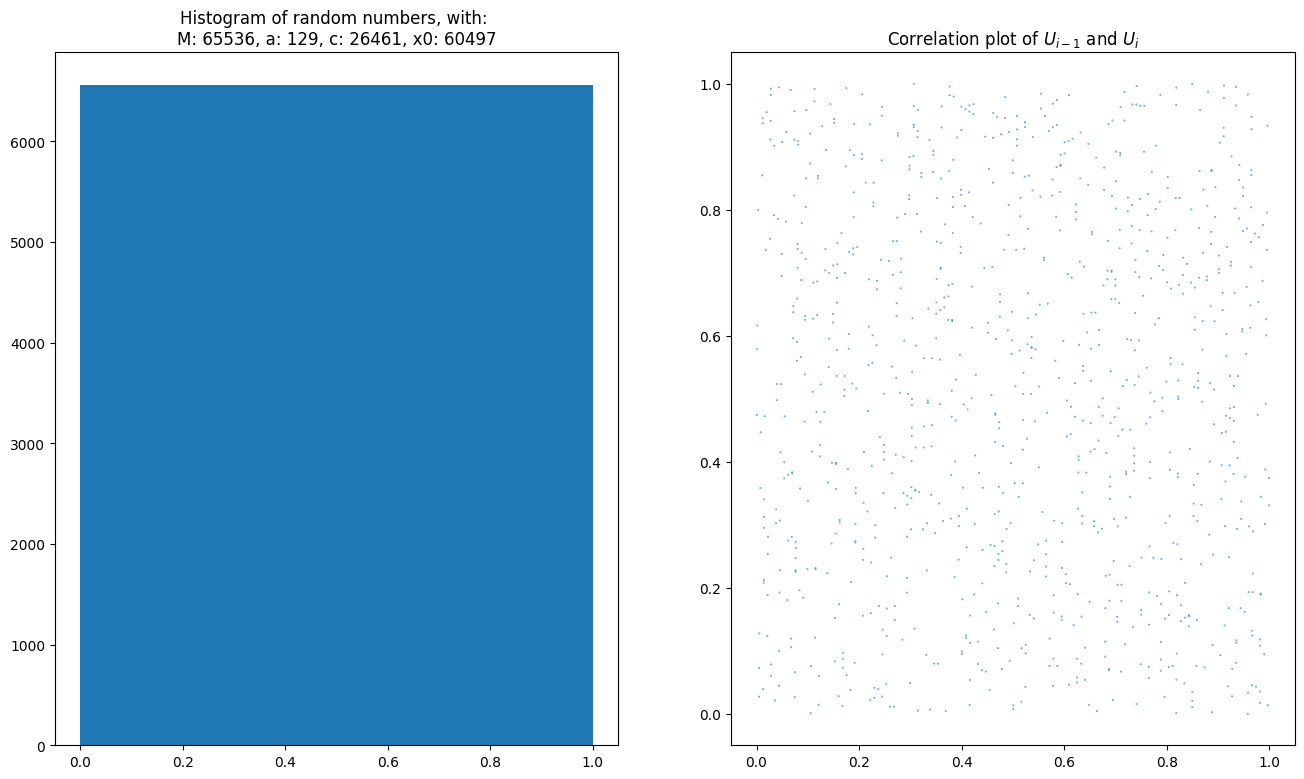

In [138]:
M_hist = 65536
multiplier_hist = 129
shift_hist = 26461
x0_hist = 420

plot_hist_and_corr(multiplier = multiplier_hist, shift =shift_hist, modulus = M_hist, x0 = None, num_bins = None, num_scatter_points = 1000)

### Test
The $\chi$-test

In [141]:
def chi_squared_test(U, num_bins):
    # For uniform expected distribution

    # Divied into bins
    counts, _ = np.histogram(U, bins=num_bins)
    n_expected  = counts.sum()/num_bins

    T = np.sum((counts-n_expected)**2/n_expected)

    df = num_bins -1 -1 # when number of estimated parameters is m=1

    print(f"Chi-squared test give : {scipy.stats.chi.cdf(T,df)}")


    

Kolmogorov Smirnov

In [209]:
def Kolmogorov_Smirnov(U):
    # For uniform expected distribution: F(x) = x

    U_sort = np.sort(U)
    n = len(U)

    D = []
    #F,Fn = [],[]
  
    for i, x ,in enumerate(U_sort):
        #F.append((i+1)/n)
        #Fn.append(np.sum(U_sort<=x)/n)
        F = (i+1)/n
        Fn = np.sum(U_sort<=x)/n
        D.append(np.abs(Fn -F))

    D_n = np.max(D)
    #print(Fn)
    #plt.figure()
    #plt.plot(F, label='F',)
    #plt.plot(Fn, label='Fn')
    #plt.legend()
    #plt.show()
    #print(D_n)
    print(f"Kolmogorov Smirnov: {1-scipy.special.kolmogorov(D_n)}")
    



In [211]:
M = 65536
a = 129
c = 26461
x0 =420
#M = 16
#a = 5
#c = 1
#x0 = 3
#M = 10**4
#a = 69
#c = 100
#x0 = 420


ranom_nums, U = linear_congruental_generator(multiplier=a, shift=c, modulus=M, x0=x0)

Kolmogorov_Smirnov(U)

Kolmogorov Smirnov: 0.0


### Run-tests

#### Up-and-Down test

In [212]:
def up_and_down_test(random_nums : list[float]):
    """
        Calculates the runs of a list of random numbers.
        
        :param random_nums: a list of random numbers.
        
        :return R: a list of runs.
    """
    R = []
    
    n = len(random_nums)
    
    previous = None
    run_length = 0
    for i in range(len(random_nums) - 1):
        if random_nums[i] < random_nums[i + 1]:
            if previous == "up" or previous is None:
                run_length += 1
                previous = "up"
            elif previous == "down":
                R.append(run_length)
                run_length = 1
                previous = "up"
        else:
            if previous == "down" or previous is None:
                run_length += 1
                previous = "down"
            elif previous == "up":
                R.append(run_length)
                run_length = 1
                previous = "down"
                
    count = collections.Counter(R)
    
    for key, val in count.items():
        expected_val = 0
        if key == 1:
            expected_val = (n + 1)/ 12
        elif key == 2:
            expected_val = (11*n -4) / 12
        else:
            expected_val = (2 * ((key**2 + 3*key + 1)*n - (key**3 + 3*key**2 - key - 4)) ) / np.math.factorial(key + 3)
        
        print(f"Expected number of runs of length: {key} is: {expected_val}. \nThe actual length is: {val}\n")
    
    X = len(R)
    Z = (X - (2 * n - 1) / 3) / np.sqrt( ((16 * n - 29) / 90) ) 
    
    return Z
            
    

#### Above/Below


In [213]:
def above_below(random_nums : list[float], median : float) -> tuple[list[int], list[int], int, int, float, float]:
    """
    
    """
    R_a = []
    R_b = []
    
    previous = None
    run_length = 0
    for random_num in random_nums:
        if random_num < median:
            if previous == "below" or previous is None:
                run_length += 1
                previous = "below"
            elif previous == "above":
                R_b.append(run_length)
                run_length = 1
                previous = "below"
        elif random_num > median:
            if previous == "above" or previous is None:
                run_length += 1
                previous = "above"
            elif previous == "below":
                R_a.append(run_length)
                run_length = 1
                previous = "above"
    
    n_1 = sum(R_a)
    n_2 = sum(R_b)
    
    mu = 2 * (n_1 * n_2) / (n_1 + n_2) + 1
    sigma = 2 * (n_1 * n_2 * (2 * n_1 * n_2 - n_1 - n_2)) / ((n_1 + n_2)**2 + (n_1 + n_2 - 1))
    
    return R_a, R_b, n_1, n_2, mu, sigma
              

#### Up/Down

In [214]:
def Up_Down(random_nums : list[float]) -> float:
    """
        :param random_nums: a list of random numbers between 0 and 1.
        
        :return Z: a list (of something I don't know yet).
    """

    n = len(random_nums)
    
    R = []
    run_length = 1
    for i in range(len(random_nums) - 1):
        if random_nums[i] < random_nums[i + 1]:
            run_length += 1
        else:
            R.append(run_length)
            run_length = 1
        

    A = np.array([
        [4529.4, 9044.9, 13568, 18091, 22615, 27892],
        [9044.9, 18097, 27139, 36187, 45234, 55789],
        [13568, 27139, 40721, 54281, 67852, 83685],
        [18091, 36187, 54281, 72414, 90470, 111580],
        [22615, 45234, 67852, 90470, 113262, 139476],
        [27892, 55789, 83685, 111580, 139476, 172860]
        ])

    B = np.array([
        [1/6],
        [5/24],
        [11/120],
        [19/720],
        [29/5040],
        [1/840]
        ])
    
    Z = (1 / (n - 6)) * (R - n * B).T @ A @ (R - n * B)
    
    return Z



#### Actually running the tests

In [215]:
M = 65536
multiplier = 129
shift = 26461
x0 = 35635

random_nums, U = linear_congruental_generator(multiplier=multiplier, shift=shift, modulus=M, x0=x0)

Z_up_and_down = up_and_down_test(U)
R_a, R_b, n_1, n_2, mu, sigma = above_below(U, 0.5)
T_above_below = R_a + R_b
Z_Up_Down = Up_Down(U)

print(f"The Z from the up-and-down test: {Z_up_and_down}. \nShould be asymptotically N(0, 1)\n")
print(f"The T from the above_below test: {T_above_below}.\n")
print(f"The Z from the up-down test: {Z_Up_Down}. \nShould be compared with a chi^2(6) dsitribution.")


Expected number of runs of length: 2 is: 60075.25. 
The actual length is: 11860

Expected number of runs of length: 1 is: 5461.5. 
The actual length is: 27326

Expected number of runs of length: 3 is: 3458.766666666667. 
The actual length is: 3843

Expected number of runs of length: 4 is: 754.1543650793651. 
The actual length is: 671

Expected number of runs of length: 5 is: 133.2750992063492. 
The actual length is: 55

The Z from the up-and-down test: 0.5929307368012613. 
Should be asymptotically N(0, 1)

The T from the above_below test: [5, 2, 1, 2, 1, 1, 1, 3, 3, 1, 1, 2, 8, 1, 1, 2, 4, 3, 2, 5, 1, 2, 3, 1, 2, 1, 3, 1, 2, 4, 4, 2, 1, 2, 1, 3, 1, 1, 1, 2, 1, 2, 1, 3, 1, 1, 1, 3, 1, 2, 1, 1, 1, 2, 1, 1, 1, 3, 3, 1, 1, 1, 1, 3, 1, 3, 1, 2, 1, 3, 1, 1, 1, 6, 2, 1, 2, 2, 1, 1, 2, 1, 2, 5, 2, 4, 4, 2, 1, 2, 1, 3, 1, 1, 3, 2, 1, 1, 2, 4, 2, 1, 1, 2, 1, 3, 1, 3, 4, 4, 2, 4, 2, 2, 2, 1, 3, 6, 1, 2, 1, 2, 1, 3, 1, 1, 2, 1, 3, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 6, 2, 1, 1, 1, 2, 1, 2